In [438]:
### Adjusting the disposable_incomes 

In [439]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd


class WealthAgent(Agent):
    def __init__(self, unique_id, model, disposable_income, dwelling, technology, bad_dwelling=False, inability=False, arrears=False):
        super().__init__(unique_id, model)
        self.disposable_income = disposable_income
        self.dwelling = dwelling
        self.technology = technology
        self.bad_dwelling = bad_dwelling
        self.inability = inability
        self.arrears = arrears
    
    @property
    def energy_cost(self):
        """Calculate and return the current energy cost for the agent."""
        return self.model.energy_price * (self.dwelling + self.technology)

    @property
    def real_cost(self):
        """Calculate and return the real energy cost for the agent respecting price cap for low-income agents."""
        return min(self.energy_cost, self.disposable_income * self.model.price_cap)

    def check_arrears(self):
        """Check if the agent has arrears and update the agent's status."""
        if self.disposable_income < self.energy_cost:
            self.arrears = True
        else:
            self.arrears = False

    def check_inability(self):
        """Check if the agent has inability to keep home adequately warm and update the agent's status."""
        # Update to check inability based on real_cost instead of energy_cost
        if self.real_cost > 0.1 * self.disposable_income:
            self.inability = True
        else:
            self.inability = False

    def improve_dwelling_or_technology(self, improvement_budget):
        """Agent can improve their dwelling or technology if they have enough disposable income."""
        # We'll need to determine the specifics of how improvements affect dwelling and technology,
        # and how much they cost.
        pass

    def step(self):
        """Define the agent's behavior in a single step of the model."""
        self.check_arrears()
        self.check_inability()


class GiniCalculationError(Exception):
    pass


class WealthModel(Model):

    @classmethod
    def calculate_gini(cls, incomes):
        incomes = np.sort(incomes)
        n = len(incomes)
        index = np.arange(1, n + 1)
        return ((np.sum((2 * index - n  - 1) * incomes)) / (n * np.sum(incomes)))

    @classmethod
    def generate_income_distribution(cls, num_people, median_income, gini_target, lower_bound):
        alpha = (gini_target + 1) / (2 - gini_target)
        for _ in range(10000):
            incomes = stats.gamma.rvs(alpha, scale=median_income/alpha, size=num_people)
            incomes = np.clip(incomes, lower_bound, None)  # None means there is no upper bound
            gini_current = cls.calculate_gini(incomes)
            if np.isclose(gini_current, gini_target, atol=0.01):
                return incomes
            elif gini_current < gini_target:
                alpha *= 0.9
            else:
                alpha *= 1.1

        error_message = f"Failed to reach target Gini coefficient in 1000 iterations. Current Gini: {gini_current}"
        raise GiniCalculationError(error_message)
        

    def assign_dwelling_and_technology(self):
        # Generate enough dwelling and technology values for all agents
        dwelling_values = np.sort(np.random.randint(500, 1800, self.num_agents))
        technology_values = np.sort(np.random.randint(200, 600, self.num_agents))

        incomes_check = [agent.disposable_income for agent in self.schedule.agents]
        lower_threshold = np.percentile(incomes_check, 25)
        upper_threshold = np.percentile(incomes_check, 75)

        # Separate agents by income levels
        low_income_agents = [a for a in self.schedule.agents if a.disposable_income < lower_threshold]
        medium_income_agents = [a for a in self.schedule.agents if lower_threshold <= a.disposable_income < upper_threshold]
        high_income_agents = [a for a in self.schedule.agents if a.disposable_income >= upper_threshold]


        # Assign high dwelling and technology values to a proportion of each income group
        for agents, proportion in zip([low_income_agents, medium_income_agents, high_income_agents], [0.6, 0.25, 0.15]):
            num_high_values = int(proportion * len(agents))
            for agent in np.random.choice(agents, num_high_values, replace=False):
                if len(dwelling_values) > 0 and len(technology_values) > 0:
                    agent.dwelling = dwelling_values[-1]
                    agent.technology = technology_values[-1]
                    dwelling_values = np.delete(dwelling_values, np.where(dwelling_values == agent.dwelling)[0][0])
                    technology_values = np.delete(technology_values, np.where(technology_values == agent.technology)[0][0])

        # Assign remaining dwelling and technology values randomly to the rest of the agents
        remaining_agents = [agent for agent in self.schedule.agents if agent.dwelling == None]
        for agent in remaining_agents:
            if len(dwelling_values) > 0 and len(technology_values) > 0:
                agent.dwelling = np.random.choice(dwelling_values)
                dwelling_values = np.delete(dwelling_values, np.where(dwelling_values == agent.dwelling)[0][0])
                agent.technology = np.random.choice(technology_values)
                technology_values = np.delete(technology_values, np.where(technology_values == agent.technology)[0][0])


    def adjust_for_inability(self):
        """Adjust the technology level of agents to meet the inability target."""
        # Calculate current inability_share
        inability_share = sum(agent.inability for agent in self.schedule.agents) / self.num_agents

        # Get list of agents sorted by absolute disp_utility
        sorted_agents = sorted(self.schedule.agents, key=lambda a: abs(a.disposable_income - a.energy_cost))

        # Adjust technology of agents close to the threshold until inability_target is met
        for agent in sorted_agents:
            if inability_share < self.inability_target and not agent.inability:
                # Increase technology level to make agent unable
                while not agent.inability:
                    agent.technology += 1
                    agent.check_inability()
                inability_share = sum(agent.inability for agent in self.schedule.agents) / self.num_agents
            elif inability_share > self.inability_target and agent.inability:
                # Decrease technology level to make agent able
                while agent.inability:
                    agent.technology -= 1
                    agent.check_inability()
                inability_share = sum(agent.inability for agent in self.schedule.agents) / self.num_agents

            # Stop adjusting if inability_share is close enough to inability_target
            if abs(inability_share - self.inability_target) < 0.01:
                break


    def __init__(self, N, median_income, min_disposal, price_cap, gini_target, rate, energy_price_x, share_fuel_x, energy_price_y, share_fuel_y,inability_target):
        self.num_agents = N
        self.median_income = median_income
        self.min_disposal = min_disposal
        self.price_cap = price_cap
        self.gini_target = gini_target
        self.rate = rate
        self.energy_price_x = energy_price_x
        self.share_fuel_x = share_fuel_x
        self.energy_price_y = energy_price_y
        self.share_fuel_y = share_fuel_y
        self.inability_target = inability_target
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            # We can update what data to collect here later.
            agent_reporters={"Dwelling": "dwelling", 
                             "Technology": "technology", 
                             "Income": "disposable_income",
                             "arrears":"arrears",
                             "Inability":"inability",
                             "EnergyCost": "energy_cost",
                             "Real Cost":"real_cost",
                             "disp_utility": lambda agent: agent.disposable_income - agent.energy_cost},
            model_reporters = {
                "Inability Over Time": lambda model: sum(agent.inability for agent in model.schedule.agents) / model.num_agents
            })

        # Generate disposable incomes according to a gamma distribution shaped by the Gini coefficient
        incomes = WealthModel.generate_income_distribution(self.num_agents, self.median_income, self.gini_target, self.min_disposal)

        # Create agents
        for i in range(self.num_agents):
            # We will update this section with the detailed logic for initializing
            # agents' dwellings, and technologies.
            a = WealthAgent(i, self, disposable_income=incomes[i], dwelling=None, technology=None)
            self.schedule.add(a)

        self.assign_dwelling_and_technology()


    @property
    def energy_price(self):
        """Calculate and return the current energy price in the model."""
        # As per your description: energy_price_x * share_fuel_x + energy_price_y * share_fuel_y
        return self.energy_price_x * self.share_fuel_x + self.energy_price_y * self.share_fuel_y


    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)
        self.schedule.step()
        self.adjust_for_inability()


model = WealthModel(1000, 3000, 500, 0.7, 0.25, [0.01, 0.05], 1, 0.5, 1, 0.5, 0.05)

for i in range(100):   # this is the simulation loop
    model.step()

agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()


In [440]:
agent_data

Dwelling  Technology       Income  arrears  Inability  \
Step AgentID                                                          
0    0            1502         509  2589.524750    False      False   
     1             942         288  4089.071812    False      False   
     2            1645         554  1771.337539    False      False   
     3            1119         391  1129.565417    False      False   
     4            1466         498  4568.102090    False      False   
...                ...         ...          ...      ...        ...   
99   995          1392       -1115  2774.375396    False      False   
     996           806        -563  2434.872934    False      False   
     997          1491       -1286  2056.603768    False      False   
     998          1599       -1303  2961.336015    False      False   
     999          1423       -1026  3970.677699    False      False   

              EnergyCost    Real Cost  disp_utility  
Step AgentID                                         
0    0            2011.0  1812.667325    578.524750  
     1            1230.0  1230.000000   2859.071812  
     2            2199.0  1239.936277   -427.662461  
     3            1510.0   790.695792   -380.434583  
     4            1964.0  1964.000000   2604.102090  
...                  ...          ...           ...  
99   995           277.0   277.000000   2497.375396  
     996           243.0   243.000000   2191.872934  
     997           205.0   205.000000   1851.603768  
     998           296.0   296.000000   2665.336015  
     999           397.0   397.000000   3573.677699  

[100000 rows x 8 columns]

In [441]:
agent_data.Inability.tail(1000).sum()/1000

0.06

In [442]:
model_data.head()

,Inability Over Time
0,0.00
1,0.06
2,0.06
3,0.06
4,0.06


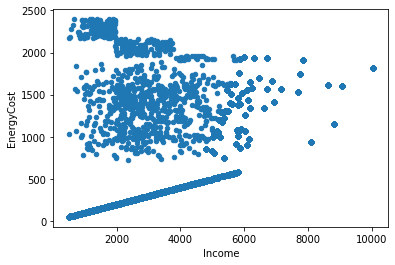

In [443]:
agent_data.reset_index().plot(kind='scatter', x='Income', y='EnergyCost')
plt.show()

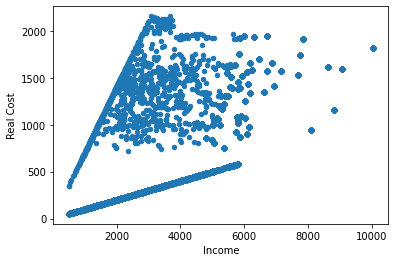

In [444]:
agent_data.reset_index().plot(kind='scatter', x='Income', y='Real Cost')
plt.show()

Income_Decile
0     114.163888
1     169.278795
2     207.386804
3     236.978685
4     268.294903
5     301.860724
6     341.508000
7     387.866000
8     449.568900
9    1015.277500
Name: Real Cost, dtype: float64


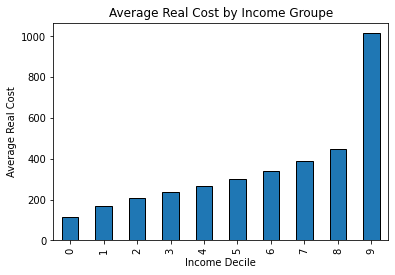

In [445]:
# Let's first sort agent_data by 'Income'
agent_data = agent_data.sort_values('Income')

# Calculate income deciles
agent_data['Income_Decile'] = pd.qcut(agent_data['Income'], 10, labels=False, duplicates='drop')

# Print average 'RealCost' for each income decile
print(agent_data.groupby('Income_Decile')['Real Cost'].mean())


import matplotlib.pyplot as plt

# Plot a histogram of 'RealCost' for each income decile
agent_data.groupby('Income_Decile')['Real Cost'].mean().plot(kind='bar', edgecolor='black')

plt.title('Average Real Cost by Income Groupe')
plt.xlabel('Income Decile')
plt.ylabel('Average Real Cost')
plt.show()


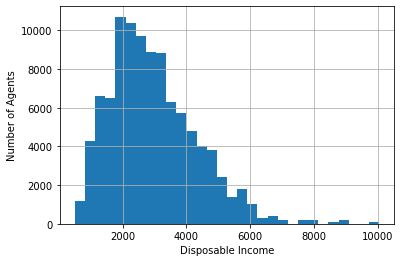

In [446]:
agent_data["Income"].hist(bins=30)
plt.xlabel('Disposable Income')
plt.ylabel('Number of Agents')
plt.show()


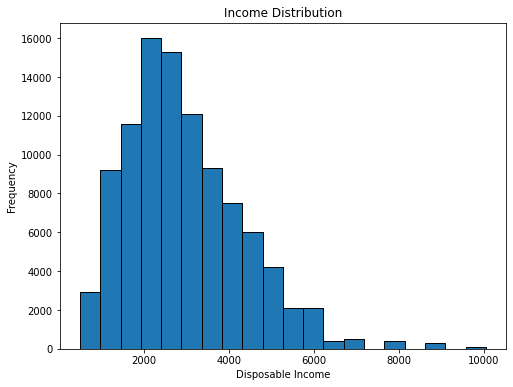

In [447]:
# Plot Income Distribution
plt.figure(figsize=(8, 6))
plt.hist(agent_data['Income'], bins=20, edgecolor='black')
plt.xlabel('Disposable Income')
plt.ylabel('Frequency')
plt.title('Income Distribution')
plt.show()


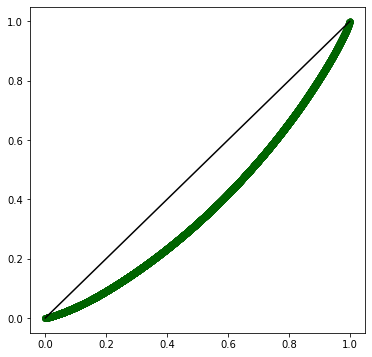

In [448]:
def plot_lorenz_curve(X, yummy_figs = (6, 6)):

    X_sorted = np.sort(X)  # Sort the incomes
    lorenz = np.cumsum(X_sorted) / np.sum(X_sorted)
    lorenz = np.insert(lorenz, 0, 0)
    lorenz[0], lorenz[-1]

    fig, ax = plt.subplots(figsize=[yummy_figs[0],yummy_figs[1]])
    ax.scatter(np.arange(lorenz.size)/(lorenz.size-1), lorenz, 
            marker='.', color='darkgreen', s=100)
    ## line plot of equality
    ax.plot([0,1], [0,1], color='k')

plot_lorenz_curve(agent_data["Income"])